<a href="https://colab.research.google.com/github/tedrosredie/PyhonProjects/blob/main/DDS8555_Week3_Applied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part (a) & (b): Generate Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# (a) Generate predictor X and noise vector epsilon
n = 100
X = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)

# (b) Generate response vector Y according to the model
# Y = β0 + β1*X + β2*X^2 + β3*X^3 + epsilon
beta0 = 1
beta1 = 2
beta2 = 3
beta3 = 4

Y = beta0 + beta1*X + beta2*(X**2) + beta3*(X**3) + epsilon

# Create polynomial features up to degree 10
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1))
feature_names = [f'X^{i+1}' for i in range(X_poly.shape[1])]


Helper Functions for Stepwise Selection Using Cp

In [ ]:
def calculate_cp(X, y, subset_idx, full_model_mse):
    """Calculate Mallows' Cp statistic"""
    if len(subset_idx) == 0:
        X_subset = np.ones((len(y), 1))
    else:
        X_subset = X[:, subset_idx]
        X_subset = np.column_stack((np.ones(X_subset.shape[0]), X_subset))

    model = sm.OLS(y, X_subset).fit()
    rss = np.sum(model.resid**2)
    p = len(subset_idx) + 1  # +1 for intercept
    n = len(y)

    cp = rss / full_model_mse + 2 * p - n
    return cp, model

def forward_stepwise_selection(X, y):
    n_features = X.shape[1]

    # Fit full model to get MSE
    X_full = np.column_stack((np.ones(X.shape[0]), X))
    full_model = sm.OLS(y, X_full).fit()
    full_model_mse = np.sum(full_model.resid**2) / (len(y) - X.shape[1] - 1)

    current_features = []
    remaining_features = list(range(n_features))
    results = []

    # Start with intercept-only model
    cp_intercept, model_intercept = calculate_cp(X, y, [], full_model_mse)
    results.append({
        'features': [],
        'cp': cp_intercept,
        'model': model_intercept
    })

    while remaining_features:
        best_cp = float('inf')
        best_feature = None
        best_model = None

        for feature in remaining_features:
            candidate_features = current_features + [feature]
            cp, model = calculate_cp(X, y, candidate_features, full_model_mse)

            if cp < best_cp:
                best_cp = cp
                best_feature = feature
                best_model = model

        current_features.append(best_feature)
        remaining_features.remove(best_feature)

        results.append({
            'features': current_features.copy(),
            'cp': best_cp,
            'model': best_model
        })

        print(f"Added feature {feature_names[best_feature]} with Cp: {best_cp:.4f}")

        # Stop if we've added enough features (10 max)
        if len(current_features) >= 10:
            break

    # Find the model with minimum Cp
    best_result = min(results, key=lambda x: x['cp'])
    return best_result, results

def backward_stepwise_selection(X, y):
    n_features = X.shape[1]

    # Fit full model to get MSE
    X_full = np.column_stack((np.ones(X.shape[0]), X))
    full_model = sm.OLS(y, X_full).fit()
    full_model_mse = np.sum(full_model.resid**2) / (len(y) - X.shape[1] - 1)

    # Start with all features
    current_features = list(range(n_features))
    results = []

    # Full model
    cp_full, model_full = calculate_cp(X, y, current_features, full_model_mse)
    results.append({
        'features': current_features.copy(),
        'cp': cp_full,
        'model': model_full
    })

    while len(current_features) > 0:
        best_cp = float('inf')
        worst_feature = None
        best_model = None

        for feature in current_features:
            candidate_features = current_features.copy()
            candidate_features.remove(feature)

            cp, model = calculate_cp(X, y, candidate_features, full_model_mse)

            if cp < best_cp:
                best_cp = cp
                worst_feature = feature
                best_model = model

        current_features.remove(worst_feature)

        results.append({
            'features': current_features.copy(),
            'cp': best_cp,
            'model': best_model
        })

        print(f"Removed feature {feature_names[worst_feature]} with Cp: {best_cp:.4f}")

    # Find the model with minimum Cp
    best_result = min(results, key=lambda x: x['cp'])
    return best_result, results


Part (c): Forward Stepwise Selection

In [ ]:
print("\n--- Forward Stepwise Selection ---")
best_forward, all_forward = forward_stepwise_selection(X_poly, Y)

print(f"\nBest model by Cp ({best_forward['cp']:.4f}):")
print(f"Selected features: {[feature_names[f] for f in best_forward['features']]}")
print("Coefficients:")
for i, coef in enumerate(best_forward['model'].params[1:]):
    feature_idx = best_forward['features'][i]
    print(f"{feature_names[feature_idx]}: {coef:.4f}")



--- Forward Stepwise Selection ---
Added feature X^3 with Cp: 1421.0865
Added feature X^2 with Cp: 103.2700
Added feature X^1 with Cp: 4.2647
Added feature X^10 with Cp: 4.3445
Added feature X^5 with Cp: 5.3047
Added feature X^9 with Cp: 7.1573
Added feature X^4 with Cp: 8.5173
Added feature X^8 with Cp: 9.3505
Added feature X^6 with Cp: 9.3863
Added feature X^7 with Cp: 11.0000

Best model by Cp (4.2647):
Selected features: ['X^3', 'X^2', 'X^1']
Coefficients:
X^3: 4.0284
X^2: 3.2069
X^1: 1.8643


Part (d): Backward Stepwise Selection

In [ ]:
print("\n--- Backward Stepwise Selection ---")
best_backward, all_backward = backward_stepwise_selection(X_poly, Y)

print(f"\nBest model by Cp ({best_backward['cp']:.4f}):")
print(f"Selected features: {[feature_names[f] for f in best_backward['features']]}")
print("Coefficients:")
for i, coef in enumerate(best_backward['model'].params[1:]):
    feature_idx = best_backward['features'][i]
    print(f"{feature_names[feature_idx]}: {coef:.4f}")



--- Backward Stepwise Selection ---
Removed feature X^9 with Cp: 9.3675
Removed feature X^7 with Cp: 7.4067
Removed feature X^5 with Cp: 5.7369
Removed feature X^4 with Cp: 5.1707
Removed feature X^6 with Cp: 6.0268
Removed feature X^8 with Cp: 4.3445
Removed feature X^10 with Cp: 4.2647
Removed feature X^1 with Cp: 103.2700
Removed feature X^2 with Cp: 1421.0865
Removed feature X^3 with Cp: 13248.0155

Best model by Cp (4.2647):
Selected features: ['X^1', 'X^2', 'X^3']
Coefficients:
X^1: 1.8643
X^2: 3.2069
X^3: 4.0284


Part (e): Lasso Regression with Cross-Validation

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.357207748260407, tolerance: 0.9634479785976513
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.03584298104579, tolerance: 0.9634479785976513
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.760233568692911, tolerance: 0.9634479785976513
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergenc

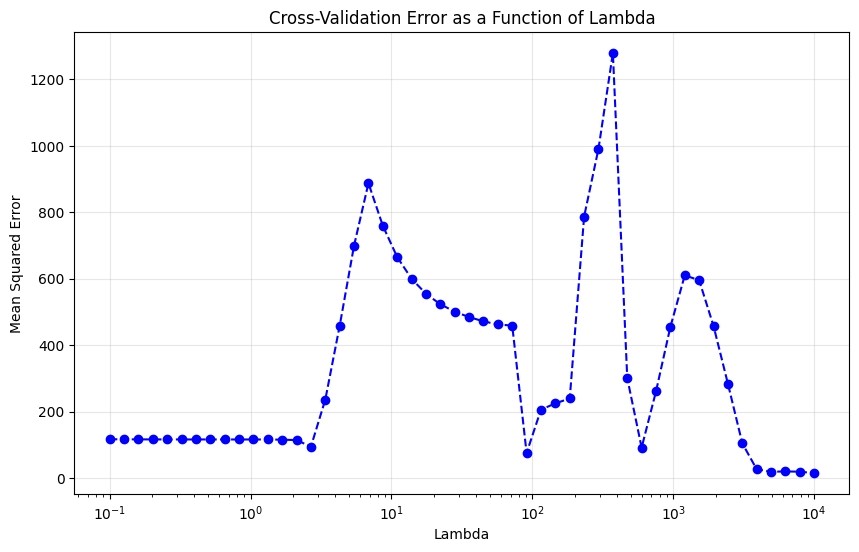


--- Lasso Regression ---
Best alpha (lambda): 0.1000
Lasso coefficients:
X^1: 1.6251
X^2: 2.2234
X^3: 4.0263
X^4: 0.3518
X^5: 0.0508
X^8: -0.0005
X^9: -0.0032
X^10: -0.0015


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+02, tolerance: 1.166e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Generate alphas (lambdas) for lasso
alphas = np.logspace(-1, 4, 50)

# Fit lasso with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_poly, Y)

# Plot cross-validation error vs lambda
plt.figure(figsize=(10, 6))
mse_path = np.mean(lasso_cv.mse_path_, axis=1)
plt.semilogx(alphas, mse_path, '--o', color='blue')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Error as a Function of Lambda')
plt.grid(True, alpha=0.3)
plt.savefig('Cross-Validation Error as a Function of Lambda.png')
plt.show()

# Get best alpha and corresponding model
best_alpha = lasso_cv.alpha_
print(f"\n--- Lasso Regression ---")
print(f"Best alpha (lambda): {best_alpha:.4f}")

# Fit lasso model with best alpha
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_poly, Y)
print("Lasso coefficients:")
for i, coef in enumerate(lasso_best.coef_):
    if abs(coef) > 1e-5:  # Only show non-zero coefficients
        print(f"{feature_names[i]}: {coef:.4f}")


In [ ]:
# Generate new response: Y = β0 + β7*X^7 + epsilon
beta0_new = 1
beta7 = 5
other_betas = np.zeros(10)
other_betas[6] = beta7  # X^7 has index 6 (0-indexed)

Y_new = beta0_new + np.dot(X_poly, other_betas) + epsilon

# Forward stepwise selection for new model
print("\n--- Forward Stepwise Selection (New Model) ---")
best_forward_new, all_forward_new = forward_stepwise_selection(X_poly, Y_new)

print(f"\nBest model by Cp ({best_forward_new['cp']:.4f}):")
print(f"Selected features: {[feature_names[f] for f in best_forward_new['features']]}")
print("Coefficients:")
for i, coef in enumerate(best_forward_new['model'].params[1:]):
    feature_idx = best_forward_new['features'][i]
    print(f"{feature_names[feature_idx]}: {coef:.4f}")

# Lasso regression for new model
lasso_cv_new = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv_new.fit(X_poly, Y_new)

best_alpha_new = lasso_cv_new.alpha_
print(f"\n--- Lasso Regression (New Model) ---")
print(f"Best alpha (lambda): {best_alpha_new:.4f}")

lasso_best_new = Lasso(alpha=best_alpha_new, random_state=42)
lasso_best_new.fit(X_poly, Y_new)
print("Lasso coefficients:")
for i, coef in enumerate(lasso_best_new.coef_):
    if abs(coef) > 1e-5:  # Only show non-zero coefficients
        print(f"{feature_names[i]}: {coef:.4f}")

# Compare results with true model
print("\n--- Comparison with True Model ---")
print("True coefficients for original model:")
print(f"β0: {beta0}, β1 (X): {beta1}, β2 (X^2): {beta2}, β3 (X^3): {beta3}")

print("\nTrue coefficients for new model:")
print(f"β0: {beta0_new}, β7 (X^7): {beta7}")



--- Forward Stepwise Selection (New Model) ---
Added feature X^7 with Cp: 6.2414
Added feature X^2 with Cp: 2.3583
Added feature X^9 with Cp: 1.7101
Added feature X^5 with Cp: 3.3167
Added feature X^3 with Cp: 4.9363
Added feature X^4 with Cp: 6.6409
Added feature X^8 with Cp: 7.3544
Added feature X^6 with Cp: 8.2891
Added feature X^10 with Cp: 9.6800
Added feature X^1 with Cp: 11.0000

Best model by Cp (1.7101):
Selected features: ['X^7', 'X^2', 'X^9']
Coefficients:
X^7: 4.9859
X^2: 0.2084
X^9: 0.0022

--- Lasso Regression (New Model) ---
Best alpha (lambda): 0.1000
Lasso coefficients:
X^1: 2.7745
X^2: -1.6426
X^3: -12.6739
X^4: 2.6514
X^5: 10.6527
X^6: -0.7454
X^7: 2.1270
X^8: -0.0025
X^9: 0.2170
X^10: 0.0036

--- Comparison with True Model ---
True coefficients for original model:
β0: 1, β1 (X): 2, β2 (X^2): 3, β3 (X^3): 4

True coefficients for new model:
β0: 1, β7 (X^7): 5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2117.2074244841624, tolerance: 1853.7683148526282
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2030.7370652751542, tolerance: 1853.7683148526282
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2144.2773126313787, tolerance: 1853.7683148526282
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Converge